Import necessary libraries

In [ ]:
# Import libraries
import numpy as np
import time
import os
import matplotlib
import matplotlib.image as mpimg
import pandas as pd
from torch import optim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
import spacy
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import cv2 
import multiprocessing as mp
import imp
import threading


%matplotlib inline

Import Data

In [ ]:
# Train data 
multi_traindata = pd.read_csv('/content/drive/MyDrive/multimodal_train.tsv',sep='\t')
# Validation data 
multi_validata = pd.read_csv('/content/drive/MyDrive/multimodal_validate.tsv',sep='\t')
# Test data 
multi_testdata = pd.read_csv('/content/drive/MyDrive/multimodal_test_public.tsv',sep='\t')

Subset of the dataframe with no missing values in the 'title' column.

In [ ]:
# Train data with no missing values
train_data = multi_traindata[multi_traindata['title'].notna()]

# Validation data with no missing values
valid_data = multi_validata[multi_validata['title'].notna()]

# Test data with no missing values
test_data = multi_testdata[multi_testdata['title'].notna()]


Separates the dataset into three sets of data: texts, labels and image names.
It firstly defines the train, validation and test dataset and then it separates the columns 'title', '6_way_label' and 'id' into separate variables.

In the train dataset, it separates the columns 'title', '6_way_label' and 'id' into three separate variables called 'train_news', 'train_labels' and 'train_images' respectively by using the .values.T property. This .values.T is used to obtain a transposed view of the dataframe, where the rows and columns are flipped.

In [ ]:
train_news, train_labels, train_images = train_data['title'].tolist(), train_data['6_way_label'].tolist(), train_data['id'].tolist()
valid_news, valid_labels, valid_images = valid_data['title'].tolist(), valid_data['6_way_label'].tolist(), valid_data['id'].tolist()
test_news, test_labels, test_images = test_data['title'].tolist(), test_data['6_way_label'].tolist(), test_data['id'].tolist()



Add the '.jpg' termination to all the image names in the previous lists.

In [ ]:
def add_suffix(images, suffix='.jpg'):
    return [image + suffix for image in images]

train_images_final = add_suffix(train_images)
valid_images_final = add_suffix(valid_images)
test_images_final = add_suffix(test_images)


Preprocessing

First, preprocess the text that will feed to the neural network. define a function to preprocess the data. remove punctuations, numbers and also multiple spaces.

Removes punctuations, numbers, and multiple spaces from the input text. The function uses regular expressions (re) to replace any non-alphabetic characters with a space and also replaces multiple spaces with a single space.

In [ ]:
import re
def preprocess_text(sentence):
    return re.sub(r'[^a-zA-Z\s]|\s+', ' ', sentence)

In [ ]:
# Preprocess the news text
train_news_clean = [preprocess_text(new) for new in train_news]
valid_news_clean = [preprocess_text(new) for new in valid_news]
test_news_clean = [preprocess_text(new) for new in test_news]


Using nltk's pos_tag() method to get the POS tag of each word and then passing that tag as an argument to the lemmatizer.

In [ ]:
from nltk import pos_tag

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

def remove_stopwords_lem(text):
    text = word_tokenize(text)
    filtered_words = [lemmatizer.lemmatize(word, pos = get_wordnet_pos(word)) for word in text if word not in stop_words]
    filtered_words
    return ' '.join(filtered_words)


from nltk.corpus import wordnet

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1]
    tag
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')

# Stop-words removal and lemmatization
# Remove stopwords and lemmatize
train_stwrd_lem = [remove_stopwords_lem(new) for new in train_news_clean]
valid_stwrd_lem = [remove_stopwords_lem(new) for new in valid_news_clean]
test_stwrd_lem = [remove_stopwords_lem(new) for new in test_news_clean]


Using the fit_on_texts() method only on the training set and then use texts_to_sequences() for both validation and test sets as well. Also, it is not necessary to set the num_words parameter to a fixed value, I can use the num_words parameter to set the maximum number of words to keep, based on word frequency.

In [ ]:


news_all = train_stwrd_lem + valid_stwrd_lem + test_stwrd_lem
tokenizer = Tokenizer(num_words = 128022)
tokenizer.fit_on_texts(news_all)
train_tokenized = tokenizer.texts_to_sequences(train_stwrd_lem)
valid_tokenized = tokenizer.texts_to_sequences(valid_stwrd_lem)
test_tokenized = tokenizer.texts_to_sequences(test_stwrd_lem)



In [ ]:
# Obtain the vocabulary length

print("Vocabulary length: ", len(tokenizer.word_index))

Vocabulary length:  110688


In [ ]:
# Pad/truncate the tokenized news
# Train
train_tokenized_padding = pad_sequences(train_tokenized, maxlen = 15, truncating='post', padding='post')

# Validation
valid_tokenized_padding = pad_sequences(valid_tokenized, maxlen = 15, truncating='post', padding='post')

# Test
test_tokenized_padding = pad_sequences(test_tokenized, maxlen = 15, truncating='post', padding='post')


**Training the model**


Removing the stripping of the last element of embd and converting embd to a float list in a single line. Also, the file can be opened and read using with statement to automatically close the file.

In [ ]:
def load_embedd(filename):
    words = []
    vectors = []
    with open(filename,'r', encoding="utf8") as file:
        for line in file:
           row = line.split(' ')
           vocab = row[0]
           embd = list(map(float, row[1:-1]))
           words.append(vocab)
           vectors.append(embd)
           words, vectors
    return words, vectors




In [ ]:
def embed_matrix(word_index, vocab, embeddings, vocab_len, embedding_len):
    embedding_matrix = np.zeros((vocab_len + 1, embedding_len))
    for word, i in word_index.items():
        if word in vocab:
            idx = vocab.index(word)
            vector = embeddings[idx]
            vector = np.pad(vector, (0, embedding_len - len(vector)), 'constant')
            embedding_matrix[i] = vector
    return embedding_matrix





Use GloVe embeddings of dimension 300.

In [ ]:
# Use GloVe embeddings of dimension 300
vocab_gv_300, vectors_gv_300 = load_embedd(filename = "/content/drive/MyDrive/SaveModels/glove.6B.300d.txt")

This way the function can use the vocab list to check if a word is present in the embeddings list before adding it to the embedding matrix.

In [ ]:
# Create the embedding matrix
word_index = tokenizer.word_index
embedding_matrix_gv_300 = embed_matrix(word_index=word_index, vocab=vocab_gv_300, embeddings=vectors_gv_300,
vocab_len=110688, embedding_len=300)






The os.path.join() function combines the different parts of the path and uses the appropriate separator for the current operating system.
This way the code will work on any operating system, regardless of the separator used in the file path.

In [ ]:
# Get names of available images
all_images = os.listdir("/content/drive/MyDrive/public_image_set/")
path = "/content/drive/MyDrive/public_image_set/"


print("length all_images:",len(all_images))


length all_images: 178112


The function will resize the image to 560x560 and fill any remaining pixels with zeroes. 

In [ ]:

def pad_images(image):
    h, w, c = image.shape
    img_reshaped = np.zeros((3, 560, 560))
    rh = min(h, 560)
    rw = min(w, 560)
    img_reshaped[0, :rh, :rw] = image[:rh, :rw, 0]
    img_reshaped[1, :rh, :rw] = image[:rh, :rw, 1]
    img_reshaped[2, :rh, :rw] = image[:rh, :rw, 2]
    return img_reshaped



This is an implementation of a deep learning model that takes both an image and a title as input, processes them with different neural network components, and outputs a prediction of a label.

In [ ]:
# Create model

class CNN_Title_Images(nn.Module):
    
    def __init__(self, image_dimx, nlabels):
        super().__init__()
        
        # Embedding layer for the titles
        self.title_embedding = nn.Embedding(
            num_embeddings=110688,
            embedding_dim=300
        )
        self.title_embedding.weight = nn.Parameter(
            torch.from_numpy(embedding_matrix_gv_300),
            requires_grad=False
        )
        
        # Convolutional layer for the images
        self.image_cnn = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 3, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Convolutional layer for the titles
        self.title_cnn = nn.ModuleList([
            nn.Conv2d(1, 50, (k, 300), padding=(k-1,0))
            for k in [2, 3, 4, 5]
        ])
        
        self.fc1 = nn.Linear(200 + 3 * 137 * 137, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, nlabels)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        # Dimension of the image at the output of the second convolutional layer
        self.final_image_dim = int(((image_dimx - 4) / 2 - 4) / 2)

    def forward(self, image, title):
        # Pass the image tensor through the CNN operations
        image = self.image_cnn(image)
        image = image.view(image.shape[0], self.final_image_dim * self.final_image_dim * 3)

        # Pass the title tensor through the different operations
        title = self.title_embedding(title)
        title = title.unsqueeze(1)
        title = [F.relu(conv(title.float())).squeeze(3) for conv in self.title_cnn]
        title = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in title] 
        title = torch.cat(title, 1)
        
        # Join image and title output
        x = torch.cat([image, title], 1)
        
        # Pass result through the linear layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.logsoftmax(x)
        return x
    



In [ ]:
# Instantiate the model
model_CNN_image_text = CNN_Title_Images(image_dimx = 560 ,nlabels = 6 )



Trains a CNN image and text classification model using PyTorch. It uses the Adam optimizer and the NLLLoss criterion to optimize the model's parameters. The training data is processed in batches of 60, and the code performs forward and backward propagation on each batch. After processing each batch, it calculates the accuracy of the model, updates the parameters using the optimizer, and resets the image, title, and label tensors. The average training accuracy is printed every 100 batches processed.

In [ ]:
# Create counter to be used in the loop
counter = 0
# Error function
criterion = nn.NLLLoss()
# Optimizer
optimizer = torch.optim.AdamW(model_CNN_image_text.parameters(), lr=0.001)
# To store training accuracy
train_accuracy = 0
# To store the number of training batches processed
train_batches_processed = 0

images_tensor = torch.zeros(60, 3, 560, 560)
titles_tensor = torch.zeros(60, 15)
labels_tensor = torch.zeros(60)

for i in range(len(train_images_final)):
    
    # First check if image is available
    img = cv2.imread(os.path.join(path, train_images_final[i])) 
        
    if type(img) is not type(None):
        counter += 1 
        
        # Pad image with zeros or truncate it to obtain 560 x 560 shape
        img_padded = pad_images(img)
        
        # Store image, corresponding title, and label 
        images_tensor[counter-1, :,:,:] = torch.from_numpy(img_padded)
        titles_tensor[counter-1, :] = torch.from_numpy(train_tokenized_padding[i]).int()
        labels_tensor[counter - 1] = train_labels[i]
           
        
        if counter % 60 == 0: 
           train_batches_processed += 1
           print("Training Batch Processed: ", train_batches_processed)

           # Reset gradients
           optimizer.zero_grad() 

           # Pass image and text through the different layers
           out = model_CNN_image_text.forward(images_tensor, titles_tensor.long())            
            # Compute loss
           loss = criterion(out, labels_tensor.long())

            
           # Backpropagation
           loss.backward()
        
           # Optimize parameters
           optimizer.step()
            
           # Obtain number of correct predictions and store accuracy
           top_p, top_class = out.topk(1, dim=1) 
           equals = (top_class == labels_tensor.view(images_tensor.shape[0], 1))
           train_accuracy += torch.mean(equals.type(torch.FloatTensor))

           # Reset image, title, and label tensors
           images_tensor = torch.zeros(60, 3, 560, 560)
           titles_tensor = torch.zeros(60, 15)
           labels_tensor = torch.zeros(60)
            
           counter = 0 
                
           # Print average accuracy every 100 training batches
           if train_batches_processed % 100 == 0:

                print("Average Training Accuracy:", train_accuracy / train_batches_processed)


Training Batch Processed:  1
Training Batch Processed:  2
Training Batch Processed:  3
Training Batch Processed:  4
Training Batch Processed:  5
Training Batch Processed:  6
Training Batch Processed:  7
Training Batch Processed:  8
Training Batch Processed:  9
Training Batch Processed:  10
Training Batch Processed:  11
Training Batch Processed:  12
Training Batch Processed:  13
Training Batch Processed:  14
Training Batch Processed:  15
Training Batch Processed:  16
Training Batch Processed:  17
Training Batch Processed:  18
Training Batch Processed:  19
Training Batch Processed:  20
Training Batch Processed:  21
Training Batch Processed:  22
Training Batch Processed:  23
Training Batch Processed:  24
Training Batch Processed:  25
Training Batch Processed:  26
Training Batch Processed:  27
Training Batch Processed:  28
Training Batch Processed:  29
Training Batch Processed:  30
Training Batch Processed:  31
Training Batch Processed:  32
Training Batch Processed:  33
Training Batch Proc

In [ ]:
# Save model
torch.save(model_CNN_image_text.state_dict(), 'model_with_images_test.pt')

Performing a validation pass on a model that combines image and text information to make predictions.

In [ ]:
# Model evaluation
counter = 0
batch_size = 60
images_tensor = torch.zeros(batch_size, 3, 560, 560)
titles_tensor = torch.zeros(batch_size, 15).int()
labels_tensor = torch.zeros(batch_size).int()

predictions = []
labels_test = []

# Validation pass
with torch.no_grad():
    for i in range(len(test_images_final)):
        # First check if image is available
        img = cv2.imread(path + test_images_final[i])
        if type(img) is not type(None):
            # Add 1 to counter
            counter += 1
            # Pad it with zeros to obtain 560 x 560 shape
            img_padded = pad_images(img)
            # Store image and corresponding title and label 
            images_tensor[counter - 1, :, :, :] = torch.from_numpy(img_padded)
            titles_tensor[counter - 1, :] = torch.from_numpy(test_tokenized_padding[i])
            labels_tensor[counter - 1] = test_labels[i] 
            if counter % batch_size == 0:
                # Pass image and text through the different layers
                out = model_CNN_image_text(images_tensor, titles_tensor)
                # Obtain predictions
                top_p, top_class = out.topk(1, dim=1)
                predictions.extend(top_class.numpy().flatten().tolist())
                labels_test.extend(labels_tensor.numpy().tolist())
                # Reset tensors
                images_tensor = torch.zeros(batch_size, 3, 560, 560)
                titles_tensor = torch.zeros(batch_size, 15).int()
                labels_tensor = torch.zeros(batch_size).int()
                counter = 0
    # Process the remaining data
    if counter > 0:
        out = model_CNN_image_text(images_tensor[:counter, ...], titles_tensor[:counter, ...])
        top_p, top_class = out.topk(1, dim=1)
        predictions.extend(top_class.numpy().flatten().tolist())
        labels_test.extend(labels_tensor[:counter].numpy().tolist())

predictions = np.array(predictions)
labels_test = np.array(labels_test)


In [ ]:
print(classification_report(labels_test, predictions, labels=[0, 1, 2, 3, 4, 5]))


              precision    recall  f1-score   support

           0       0.76      0.93      0.83      5448
           1       0.70      0.75      0.72       823
           2       0.80      0.53      0.64      2610
           3       0.51      0.10      0.16       267
           4       1.00      0.99      1.00      4049
           5       0.87      0.60      0.71       549

    accuracy                           0.83     13746
   macro avg       0.77      0.65      0.68     13746
weighted avg       0.83      0.83      0.82     13746



In [ ]:
# Confusion matrix
print(confusion_matrix(np.array(labels_test).reshape(len(labels_test),1),predictions))

[[5052  119  255    7    1   14]
 [ 171  618   22    6    0    6]
 [1093  112 1379    4    2   20]
 [ 194   19   20   26    1    7]
 [   8    4    9    1 4027    0]
 [ 153   17   44    7    0  328]]


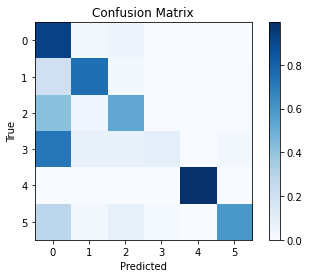

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix
cm = confusion_matrix(np.array(labels_test).reshape(len(labels_test),1),predictions)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
acc = accuracy_score(np.array(labels_test).reshape(len(labels_test),1),predictions)

# Calculate precision
precision = precision_score(np.array(labels_test).reshape(len(labels_test),1),predictions, average='macro')

# Calculate recall
recall = recall_score(np.array(labels_test).reshape(len(labels_test),1),predictions, average='macro')

# Calculate F1-score
f1 = f1_score(np.array(labels_test).reshape(len(labels_test),1),predictions, average='macro')

print("Accuracy: {:.2f}%".format(acc * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-score: {:.2f}%".format(f1 * 100))


Accuracy: 83.15%
Precision: 77.23%
Recall: 64.93%
F1-score: 67.69%
